# Tutorial on Variational Quantum Eigensolver (Part II)
## Inside the *Qiskit* implementation of VQE
---
This part of the tutorial is completely based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

During this Tutorial we will use the VQE implementation of Qiskit and investigate what is going on.

To that end we will continue working with the same 'Max-Cut' algorithm we saw last time.
........



## Import libraries 

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.


In [36]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

# Import Qiskit libraries
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.INFO)  # choose INFO, DEBUG to see the log

## Bla   ############# EDIT


[[0. 3. 1. 3. 0.]
 [3. 0. 0. 0. 2.]
 [1. 0. 0. 3. 0.]
 [3. 0. 3. 0. 2.]
 [0. 2. 0. 2. 0.]]


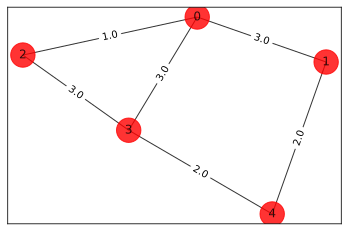

In [48]:
# Generating a graph of 5 nodes

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,3.0),(0,2,1.0),(0,3,3.0),(1,4,2.0),(3,4,2.0),(2,3,3.0)]
# tuple is (i,j,weight) where (i,j) is the edge

G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']


draw_graph(G, colors, pos)
print(w)


# Classical Approaches
## Brute Force Approach $2^n$ calculations.


Best solution = [0, 1, 0, 1, 0] cost = 13.0


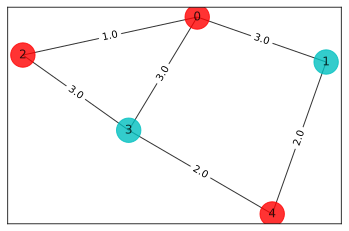

In [54]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

## Classical eigensolver for Quadratic Problem

In [51]:
# mapping Ising Hamiltonian to Quadratic Program and solving using exact classical eigensolver
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

minimize
 [ - 7 x_0^2 + 6 x_0*x_1 + 2 x_0*x_2 + 6 x_0*x_3 - 5 x_1^2 + 4 x_1*x_4
 - 4 x_2^2 + 6 x_2*x_3 - 8 x_3^2 + 4 x_3*x_4 - 4 x_4^2 ];
 
subject to {

}
optimal function value: -13.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS


## Hamiltonian Operator

In [49]:
# Create MaxCut Hamiltonian Operator with Qiskit
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -7.0
Ising Hamiltonian:
IIIZZ	(1.5+0j)
IIZIZ	(0.5+0j)
IZIIZ	(1.5+0j)
IZZII	(1.5+0j)
ZIIZI	(1+0j)
ZZIII	(1+0j)



energy: -6.0
max-cut objective: -13.0
solution: [1 0 1 0 1]
solution objective: 13.0


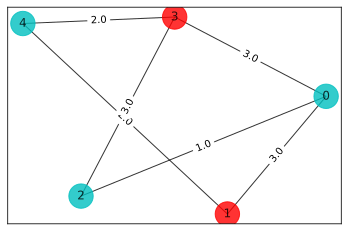

In [42]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

# Quantum Approaches
## Quantum Simulation with VQE

In [52]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

2021-01-14 01:23:36,141:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, changing shots from 1024 to 1.
2021-01-14 01:23:36,142:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None


2021-01-14 01:23:37,115:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: <qiskit.aqua.operators.converters.circuit_sampler.CircuitSampler object at 0x000001879D9F9400>
-- expectation: <qiskit.aqua.operators.expectations.matrix_expectation.MatrixExpectation object at 0x000001879D9F90D0>
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  1.5 * IIIZZ,
  0.5 * IIZIZ,
  1.5 * IZIIZ,
  1.5 * IZZII,
  ZIIZI,
  ZZIII
])
-- quantum_instance: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2'

2021-01-14 01:23:37,117:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 2.2915011  -5.60685044 -3.51406148 -3.9663008  -4.07268656  3.92189524
  5.31991014 -2.80764892  4.01815433  4.89953608  0.16299155 -3.20486934
  4.07454007 -3.59696069  3.03436447  1.63287677  5.37095801 -3.36894106
  3.75891723  0.22826859 -3.37337151 -4.19837424 -0.02778464  1.03954849
 -3.96672584 -6.09601026 -0.36275054  2.86819025  5.26028892  1.57750684]
2021-01-14 01:23:37,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2021-01-14 01:23:37,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.46971329] - 5.99504 (ms), eval count: 50
2021-01-14 01:23:37,520:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.34083595] - 5.00083 (ms), eval count: 51
2021-01-14 01:23:37,529:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.90111368] - 8.00323 (ms), eval count: 52
2021-01-14 01:23:37,541:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.02933945] - 9.99904 (ms), eval count: 53
2021-01-14 01:23:37,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.80472276] - 6.00457 (ms), eval count: 54
2021-01-14 01:23:37,556:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.69414275] - 6.00004 (ms), eval count: 55
2021-01-14 01:23:37,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation 

2021-01-14 01:23:37,933:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.43569042] - 4.99797 (ms), eval count: 105
2021-01-14 01:23:37,940:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.98683253] - 6.00123 (ms), eval count: 106
2021-01-14 01:23:37,949:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.1824889] - 7.99942 (ms), eval count: 107
2021-01-14 01:23:37,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.1974872] - 6.00100 (ms), eval count: 108
2021-01-14 01:23:37,964:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.30636764] - 6.00028 (ms), eval count: 109
2021-01-14 01:23:37,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.49062094] - 4.99749 (ms), eval count: 110
2021-01-14 01:23:37,976:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-14 01:23:38,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.22896445] - 7.02691 (ms), eval count: 159
2021-01-14 01:23:38,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.16312859] - 9.00364 (ms), eval count: 160
2021-01-14 01:23:38,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.32766033] - 5.99885 (ms), eval count: 161
2021-01-14 01:23:38,359:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.9913668] - 7.00092 (ms), eval count: 162
2021-01-14 01:23:38,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.22219873] - 6.99663 (ms), eval count: 163
2021-01-14 01:23:38,378:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.1027476] - 8.00037 (ms), eval count: 164
2021-01-14 01:23:38,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-14 01:23:38,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.52560141] - 6.99854 (ms), eval count: 213
2021-01-14 01:23:38,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49909372] - 6.00219 (ms), eval count: 214
2021-01-14 01:23:38,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.4654096] - 9.02891 (ms), eval count: 215
2021-01-14 01:23:38,813:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.49961254] - 6.00004 (ms), eval count: 216
2021-01-14 01:23:38,820:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.1872055] - 5.99670 (ms), eval count: 217
2021-01-14 01:23:38,827:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.59168957] - 6.00195 (ms), eval count: 218
2021-01-14 01:23:38,833:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-14 01:23:39,210:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77039347] - 6.00243 (ms), eval count: 267
2021-01-14 01:23:39,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.68075074] - 7.03979 (ms), eval count: 268
2021-01-14 01:23:39,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71047112] - 7.03025 (ms), eval count: 269
2021-01-14 01:23:39,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.68298099] - 5.00369 (ms), eval count: 270
2021-01-14 01:23:39,240:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69788627] - 5.96023 (ms), eval count: 271
2021-01-14 01:23:39,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.65005065] - 4.98748 (ms), eval count: 272
2021-01-14 01:23:39,254:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-14 01:23:39,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7796576] - 7.00283 (ms), eval count: 321
2021-01-14 01:23:39,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76130631] - 5.00441 (ms), eval count: 322
2021-01-14 01:23:39,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.76633768] - 5.00393 (ms), eval count: 323
2021-01-14 01:23:39,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.77775369] - 6.00171 (ms), eval count: 324
2021-01-14 01:23:39,638:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.84933489] - 4.95577 (ms), eval count: 325
2021-01-14 01:23:39,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83694596] - 5.96237 (ms), eval count: 326
2021-01-14 01:23:39,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-14 01:23:39,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.79064693] - 6.00338 (ms), eval count: 375
2021-01-14 01:23:39,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82811686] - 7.00498 (ms), eval count: 376
2021-01-14 01:23:40,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.89416991] - 5.99980 (ms), eval count: 377
2021-01-14 01:23:40,014:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.91888901] - 9.00030 (ms), eval count: 378
2021-01-14 01:23:40,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88320284] - 6.99806 (ms), eval count: 379
2021-01-14 01:23:40,033:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86694821] - 8.98767 (ms), eval count: 380
2021-01-14 01:23:40,042:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-14 01:23:40,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69005183] - 7.00045 (ms), eval count: 429
2021-01-14 01:23:40,461:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.67365407] - 7.99608 (ms), eval count: 430
2021-01-14 01:23:40,470:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90735467] - 8.00323 (ms), eval count: 431
2021-01-14 01:23:40,478:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92788723] - 6.99854 (ms), eval count: 432
2021-01-14 01:23:40,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8361066] - 8.00085 (ms), eval count: 433
2021-01-14 01:23:40,497:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86083306] - 5.99122 (ms), eval count: 434
2021-01-14 01:23:40,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-14 01:23:40,846:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86245899] - 5.99885 (ms), eval count: 483
2021-01-14 01:23:40,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8652143] - 7.04980 (ms), eval count: 484
2021-01-14 01:23:40,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.69898216] - 6.01697 (ms), eval count: 485
2021-01-14 01:23:40,868:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74750167] - 6.00100 (ms), eval count: 486
2021-01-14 01:23:40,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.889669] - 6.01125 (ms), eval count: 487
2021-01-14 01:23:40,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90383535] - 6.00123 (ms), eval count: 488
2021-01-14 01:23:40,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-01-14 01:23:41,286:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.93986329] - 5.99742 (ms), eval count: 537
2021-01-14 01:23:41,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.91446339] - 7.99584 (ms), eval count: 538
2021-01-14 01:23:41,305:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81957054] - 7.00212 (ms), eval count: 539
2021-01-14 01:23:41,315:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.80266587] - 9.00412 (ms), eval count: 540
2021-01-14 01:23:41,325:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88931819] - 8.00991 (ms), eval count: 541
2021-01-14 01:23:41,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.86520775] - 6.00195 (ms), eval count: 542
2021-01-14 01:23:41,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-01-14 01:23:41,711:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.81565985] - 7.99704 (ms), eval count: 591
2021-01-14 01:23:41,717:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8014695] - 4.97341 (ms), eval count: 592
2021-01-14 01:23:41,726:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.93062892] - 6.99806 (ms), eval count: 593
2021-01-14 01:23:41,733:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.92308494] - 5.96929 (ms), eval count: 594
2021-01-14 01:23:41,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.8287059] - 6.02531 (ms), eval count: 595
2021-01-14 01:23:41,748:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.82150514] - 5.95593 (ms), eval count: 596
2021-01-14 01:23:41,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-14 01:23:42,220:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90502482] - 5.99885 (ms), eval count: 645
2021-01-14 01:23:42,226:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.896782] - 4.99701 (ms), eval count: 646
2021-01-14 01:23:42,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.90173244] - 8.00061 (ms), eval count: 647
2021-01-14 01:23:42,243:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.89959548] - 5.99980 (ms), eval count: 648
2021-01-14 01:23:42,250:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.7761288] - 5.99504 (ms), eval count: 649
2021-01-14 01:23:42,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.75170985] - 4.99606 (ms), eval count: 650
2021-01-14 01:23:42,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

energy: -5.983735567440303
time: 5.148975372314453
max-cut objective: -12.983735567440302
solution: [0. 1. 0. 1. 0.]
solution objective: 13.0


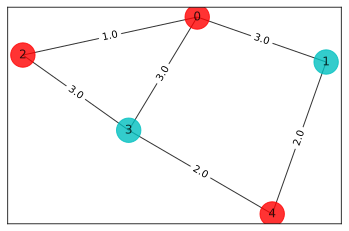

In [53]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

2021-01-14 01:15:06,101:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
initial point=[ 3.37250625 -1.50457139 -3.0374978   6.25408739  4.55907885 -2.01113474
 -0.52996851 -3.73874276 -3.13063026  6.0886955   4.37296954  5.04974298
  5.73554349  5.61175855  0.7583967   1.06314166  0.07299408  3.81859126
 -5.5354316   1.98666089 -3.55393869 -3.79395639 -2.47186538 -1.09140895
 -2.63451566  1.79065011  3.50777346  2.40182509  4.86214053  5.5863363 ]
2021-01-14 01:15:06,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2021-01-14 01:15:06,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.42856601] - 6.99949 (ms), eval count: 50
2021-01-14 01:15:06,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [3.94452646] - 8.00848 (ms), eval count: 51
2021-01-14 01:15:06,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.35464002] - 8.00490 (ms), eval count: 52
2021-01-14 01:15:06,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.56553293] - 5.99742 (ms), eval count: 53
2021-01-14 01:15:06,570:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.7986893] - 8.00180 (ms), eval count: 54
2021-01-14 01:15:06,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.00882944] - 9.01914 (ms), eval count: 55
2021-01-14 01:15:06,589:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation retu

2021-01-14 01:15:07,048:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.55664014] - 7.99990 (ms), eval count: 105
2021-01-14 01:15:07,056:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.68473579] - 5.99933 (ms), eval count: 106
2021-01-14 01:15:07,064:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.31486308] - 7.00068 (ms), eval count: 107
2021-01-14 01:15:07,072:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.65785512] - 5.99575 (ms), eval count: 108
2021-01-14 01:15:07,080:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.58980723] - 7.01308 (ms), eval count: 109
2021-01-14 01:15:07,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.19399208] - 9.00149 (ms), eval count: 110
2021-01-14 01:15:07,101:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluati

2021-01-14 01:15:07,540:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [2.26706788] - 8.99720 (ms), eval count: 160
2021-01-14 01:15:07,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.64418852] - 9.00149 (ms), eval count: 161
2021-01-14 01:15:07,560:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.59232328] - 6.99735 (ms), eval count: 162
2021-01-14 01:15:07,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.33234913] - 10.00214 (ms), eval count: 163
2021-01-14 01:15:07,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.79526386] - 10.00190 (ms), eval count: 164
2021-01-14 01:15:07,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.39629268] - 9.99570 (ms), eval count: 165
2021-01-14 01:15:07,607:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-01-14 01:15:08,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.63874692] - 10.00595 (ms), eval count: 215
2021-01-14 01:15:08,094:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.61723152] - 6.00195 (ms), eval count: 216
2021-01-14 01:15:08,103:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.13579196] - 5.98311 (ms), eval count: 217
2021-01-14 01:15:08,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.25763386] - 4.99868 (ms), eval count: 218
2021-01-14 01:15:08,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.39889052] - 6.99782 (ms), eval count: 219
2021-01-14 01:15:08,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.95932606] - 10.00023 (ms), eval count: 220
2021-01-14 01:15:08,141:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-01-14 01:15:08,571:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.97711852] - 5.99885 (ms), eval count: 270
2021-01-14 01:15:08,581:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.65023973] - 8.00180 (ms), eval count: 271
2021-01-14 01:15:08,588:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.2914308] - 5.99718 (ms), eval count: 272
2021-01-14 01:15:08,595:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.28755437] - 5.99957 (ms), eval count: 273
2021-01-14 01:15:08,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.72957949] - 7.00188 (ms), eval count: 274
2021-01-14 01:15:08,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.1287311] - 4.99964 (ms), eval count: 275
2021-01-14 01:15:08,620:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation

2021-01-14 01:15:09,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.71911494] - 7.99918 (ms), eval count: 325
2021-01-14 01:15:09,059:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.85753344] - 6.99639 (ms), eval count: 326
2021-01-14 01:15:09,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.12800536] - 8.00085 (ms), eval count: 327
2021-01-14 01:15:09,075:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.42010197] - 4.99845 (ms), eval count: 328
2021-01-14 01:15:09,086:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.3706107] - 9.00221 (ms), eval count: 329
2021-01-14 01:15:09,093:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.18128252] - 6.00004 (ms), eval count: 330
2021-01-14 01:15:09,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluatio

2021-01-14 01:15:09,514:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.34181805] - 7.00140 (ms), eval count: 380
2021-01-14 01:15:09,521:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.12649799] - 6.00171 (ms), eval count: 381
2021-01-14 01:15:09,528:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [1.40309548] - 4.99821 (ms), eval count: 382
2021-01-14 01:15:09,536:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.02966317] - 5.00059 (ms), eval count: 383
2021-01-14 01:15:09,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.95893802] - 4.99725 (ms), eval count: 384
2021-01-14 01:15:09,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.05666439] - 7.00045 (ms), eval count: 385
2021-01-14 01:15:09,559:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-01-14 01:15:10,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.16596779] - 103.31869 (ms), eval count: 435
2021-01-14 01:15:10,091:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.60504567] - 13.79490 (ms), eval count: 436
2021-01-14 01:15:10,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.46192702] - 8.00061 (ms), eval count: 437
2021-01-14 01:15:10,110:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.00102038] - 5.99241 (ms), eval count: 438
2021-01-14 01:15:10,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.36614017] - 6.99806 (ms), eval count: 439
2021-01-14 01:15:10,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.15881062] - 9.99928 (ms), eval count: 440
2021-01-14 01:15:10,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-01-14 01:15:10,534:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.64673463] - 7.00092 (ms), eval count: 490
2021-01-14 01:15:10,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.40142659] - 7.09939 (ms), eval count: 491
2021-01-14 01:15:10,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.25444551] - 4.99582 (ms), eval count: 492
2021-01-14 01:15:10,555:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.2492649] - 5.99933 (ms), eval count: 493
2021-01-14 01:15:10,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.42896297] - 6.03151 (ms), eval count: 494
2021-01-14 01:15:10,570:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.27040508] - 5.98550 (ms), eval count: 495
2021-01-14 01:15:10,576:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalua

2021-01-14 01:15:10,936:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.21391508] - 6.00123 (ms), eval count: 545
2021-01-14 01:15:10,943:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.05131824] - 6.00028 (ms), eval count: 546
2021-01-14 01:15:10,950:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.45403859] - 5.99957 (ms), eval count: 547
2021-01-14 01:15:10,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.17037419] - 7.03406 (ms), eval count: 548
2021-01-14 01:15:10,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.23376633] - 6.03104 (ms), eval count: 549
2021-01-14 01:15:10,974:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.04811994] - 4.99034 (ms), eval count: 550
2021-01-14 01:15:10,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-01-14 01:15:11,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.21504457] - 5.99861 (ms), eval count: 600
2021-01-14 01:15:11,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.51361602] - 6.01172 (ms), eval count: 601
2021-01-14 01:15:11,384:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.08690178] - 7.00045 (ms), eval count: 602
2021-01-14 01:15:11,393:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.2083483] - 7.02739 (ms), eval count: 603
2021-01-14 01:15:11,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.41486529] - 6.00147 (ms), eval count: 604
2021-01-14 01:15:11,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.03427826] - 5.99909 (ms), eval count: 605
2021-01-14 01:15:11,414:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

optimal function value: -13.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS


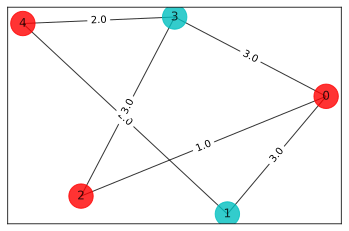

In [47]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

---
This part of the tutorial is completely based on the [Max-Cut and Traveling Salesman Problem](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html) which is part of the IBM Qiskit documentation.

---